In [11]:
import pandas as pd
from neuralnetwork import evaluate_models, models
import data_processing
from sklearn.model_selection import train_test_split
from mmr_predictor import mmr
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
import importlib
importlib.reload(mmr)

<module 'mmr_predictor.mmr' from 'C:\\Users\\Aili\\AnacondaProjects\\Drafter\\mmr_predictor\\mmr.py'>

In [29]:
def plot_history(history):
    fig, ax = plt.subplots(2)
    ax[0].plot(history.history['loss'], label = "train", marker = ".")
    ax[0].plot(history.history['val_loss'], label = "test", marker = "o")
    ax[0].set(xlabel = "epoch", ylabel = "loss")
    ax[0].legend()
    
    ax[1].plot(history.history['acc'], label = "train", marker = ".")
    ax[1].plot(history.history['val_acc'], label = "test", marker = "o")
    ax[1].set(xlabel = "epoch", ylabel = "accuracy")
    ax[1].legend()

# Drafting in online games
There are several online games where before the actual match starts the players get to choose which characters they want to play. This is called the drafting phase. Depending on the design and balance of the characters the drafting phase may have a huge impact on the result of the game. In this document I will experiment on how well it is possible to predict the winner of game where two teams battle each other based on which characters they chose. The purpose of this document is to get a rough idea of what works and what doesn't so that later on it is easier to select the best hyperparameters.

## Data
The data I collected for the development of the predictor is from the game Heroes of the Storm. Players can upload their games to a fan driven API called HotsAPI. I used their big query database to collect data on games between 1st of October 2018 and 23th of January 2019. I chose to use the largest game mode, QuickMatch, and patch, 2.40, for model selection.

After removing rows with missing values (these are rows where one or more characters was logged incorrectly into the database) and splitting the data into training and test sets the training set has 109 564 games and the test set 27 391 games. It is important to preserve the order of the games so that the evolution of the characters from patch to patch is included in the data.

In [3]:
%%time
replays = pd.read_csv("data/processed/teams_20181001-20190123_processed.csv", parse_dates = ["game_date"])
replays = (replays[(replays["game_type"] == "QuickMatch") & (replays["game_version"].str.startswith("2.40"))]
               .sort_values("game_date")
               .dropna())

cut = int(len(replays)*0.8)
train, test = replays.iloc[:cut], replays.iloc[cut:]

Wall time: 2min 55s


In [4]:
print("Length of train set: {}".format(len(train)))
print("Length of test set: {}".format(len(test)))

Length of train set: 109564
Length of test set: 27391


## Traditional machine learning methods
In this section I try out some often used machine learning methods. Starting with logistic regression and a simple neural network. I will also try a siamese network structure.

### Data preprocessing
For the neural network I encode the heroes, maps and modes. I will represent each team as a vector with 100 elements. Each element is either 1 if a hero corresponding to that index is in the team or 0 if it is not. Similarly I will encode the maps and game modes into vectors of length 20 and 10 respectively. These features are duplicated for each team. This leads to in total 260 features per game, 130 for each team. I also include a column for each team that represents the ranking of that team in the match, 1 for the winner team and 0 for the loser.

In [5]:
%%time
nn_train = (train.apply(data_processing.encode_row, axis = 1)
                 .apply(data_processing.binary_encode, axis = 1)
           )
nn_test = (test.apply(data_processing.encode_row, axis = 1)
                 .apply(data_processing.binary_encode, axis = 1)
           )

Wall time: 4min 16s


### Simple neural network

In [9]:
X_train = nn_train.iloc[:, :-2]
X_test = nn_test.iloc[:, :-2]
y_train = nn_train.iloc[:, -2:]
y_test = nn_test.iloc[:, -2:]

#### Logistic regression
I am using keras for the neural network models. Making a logistic regression model with keras is simple, I just need to make a neural network with no hidden layers and a softmax activation for the output layer. Logistic regression achieves around 57.5% accuracy.

Logistic regression: best validation loss: 0.677, validation accuracy: 0.572


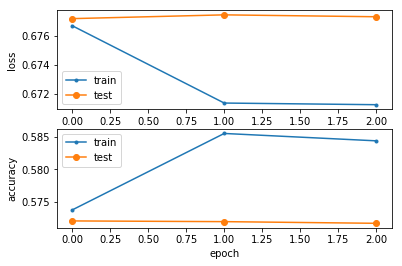

In [30]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 0, dropout = 0,
                                 verbose = 0, epochs = 10)
print("Logistic regression: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history) 

#### A simple neural network
The next model is a simple neural network with one hidden layer with varying number of hidden nodes. The hidden layer has ReLU  activation (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). All of the models perform similarly on the test set with around 58% accuracy.

NN with 10 hidden nodes: best validation loss: 0.674, validation accuracy: 0.577


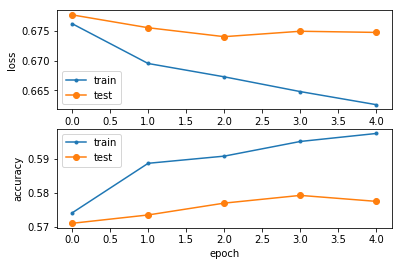

In [31]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 10,
                                 dropout = 0,
                                 verbose = 0, epochs = 10)
print("NN with 10 hidden nodes: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

NN with 10 hidden nodes: best validation loss: 0.675, validation accuracy: 0.580


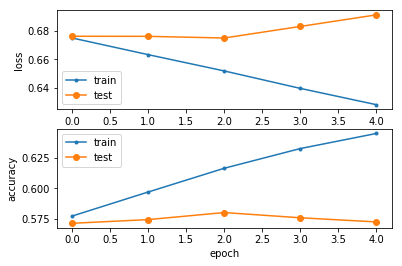

In [32]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 100,
                                 dropout = 0,
                                 verbose = 0, epochs = 10)
print("NN with 100 hidden nodes: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

NN with 200 hidden nodes: best validation loss: 0.674, validation accuracy: 0.579


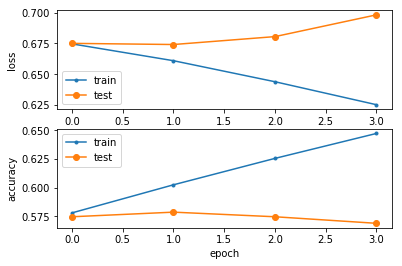

In [33]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 200,
                                 dropout = 0,
                                 verbose = 0, epochs = 10)
print("NN with 200 hidden nodes: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

#### Dropout on the simple model
The models above are overfitting after just a couple of epochs. Adding a dropout layer does seem to regulate the fitting so that overfitting happens later on but does not seem to increase test accuracy.

NN with 100 hidden nodes and 30% dropout: best validation loss: 0.673, validation accuracy: 0.577


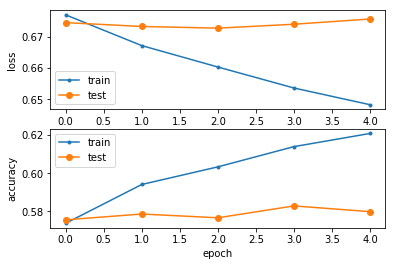

In [36]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 100,
                                 dropout = 0.3, verbose = 0, epochs = 10)
print("NN with 100 hidden nodes and 30% dropout: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

NN with 100 hidden nodes and 50% dropout: best validation loss: 0.673, validation accuracy: 0.578


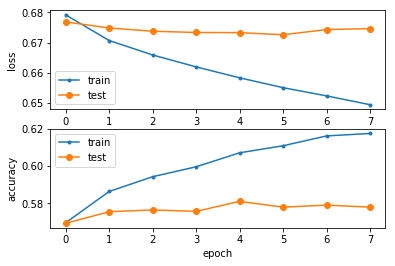

In [34]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 100,
                                 dropout = 0.5, verbose = 0, epochs = 10)
print("NN with 100 hidden nodes and 50% dropout: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

NN with 100 hidden nodes and 70% dropout: best validation loss: 0.673, validation accuracy: 0.579


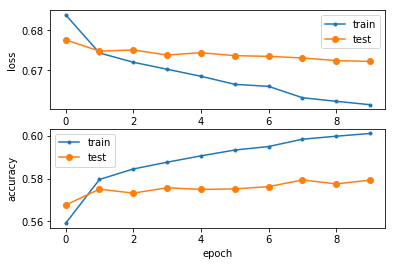

In [35]:
model, history = evaluate_models.fit_simple_model(X_train, X_test, y_train, y_test,
                                 num_hid_layers = 1, num_hid_nodes = 100,
                                 dropout = 0.7, verbose = 0, epochs = 10)
print("NN with 100 hidden nodes and 70% dropout: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

### Siamese model
A siamese model consists of subnetworks that share weights. In this model I split the features so that each team has 130 features. These features are then fed into two identical neural networks that are later combined into one network that gives the output. I was inspired to try this approach after finding this (https://github.com/HairyBlob/HotS-Drafter) project in GitHub.

Let us first try simple models where both the siamese network and the combined network have one hidden layer.

In [37]:
X_train = [nn_train.iloc[:, :130], nn_train.iloc[:, 130:-2]]
X_test = [nn_test.iloc[:, :130], nn_test.iloc[:, 130:-2]]
y_train = nn_train.iloc[:, -2:]
y_test = nn_test.iloc[:, -2:]

Siamese NN with 10 hidden nodes per layer: best validation loss: 0.674, validation accuracy: 0.580


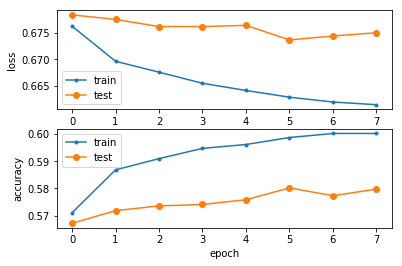

In [38]:
model, history = evaluate_models.fit_siamese_model(X_train, X_test, y_train, y_test,
                                                   num_siam_layers = 1, num_siam_nodes = 10,
                                                   num_hid_layers = 1, num_hid_nodes = 10,
                                                   verbose = 0, epochs = 10)
print("Siamese NN with 10 hidden nodes per layer: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

Siamese NN with 100 hidden nodes per layer: best validation loss: 0.676, validation accuracy: 0.575


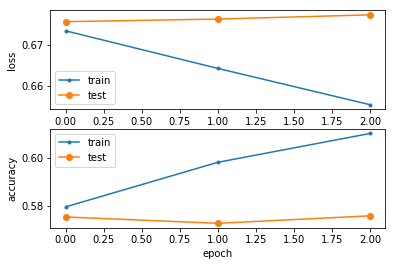

In [39]:
model, history = evaluate_models.fit_siamese_model(X_train, X_test, y_train, y_test,
                                                   num_siam_layers = 1, num_siam_nodes = 100,
                                                   num_hid_layers = 1, num_hid_nodes = 100,
                                                   verbose = 0, epochs = 10)
print("Siamese NN with 100 hidden nodes per layer: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

Siamese NN with 100 hidden nodes in siamese layer and 10 hidden nodes in hidden layer: best validation loss: 0.675, validation accuracy: 0.577


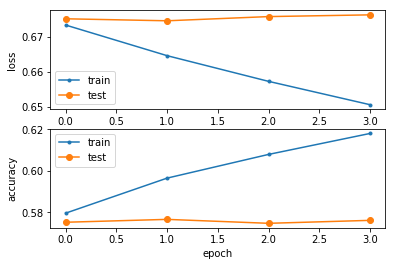

In [40]:
model, history = evaluate_models.fit_siamese_model(X_train, X_test, y_train, y_test,
                                                   num_siam_layers = 1, num_siam_nodes = 100,
                                                   num_hid_layers = 1, num_hid_nodes = 10,
                                                   verbose = 0, epochs = 10)
print("Siamese NN with 100 hidden nodes in siamese layer and 10 hidden nodes in hidden layer: best validation loss: {:.3f}, validation accuracy: {:.3f}"
          .format(history.history["val_loss"][-3],history.history["val_acc"][-3]))
plot_history(history)

## TrueSkill
TrueSkill is a skill rating system developed by Microsoft that is used to estimate player skill levels is many games. Here I am using it to estimate the power level of a character. This is a step ahead of using just win rates for the estimation since TrueSkill takes into account the power of the opponent as well. Winning against a better hero is valued more by the algorithm than winning against a weaker hero.

In summary the power of each hero is represented as a normal distribution with mean $\mu$ and standard deviation $\sigma$. This power is learned from historical data by updating $\mu$ and $\sigma$ after each game depending on whether the hero won or lost. A win increases $\mu$ and a loss decreases it, $\sigma$ decrases after each game. In my model $\sigma$ or the uncertainty of the model on a single hero increases after each patch to allow the change in power level for those heroes that got some changes.

Using the learned $\mu$ and $\sigma$ values for each hero in a game it is possible to calculate the probability that a certain team will win. I use this win probability in the same way as the output of the neural network and predict that the winner is the team with larger probability to win.

I am using this (https://trueskill.org/) Python implementation of trueskill.

In [41]:
env = mmr.trueskill.setup(beta = 1, tau = 0, draw_probability = 0)
    
mmr_dict = mmr.calculate_mmr(train, env)

Calculating mmr...


TrueSkill seems to perform similarly to the neural network.

In [48]:
print("accuracy: {:.3f}".format(mmr.accuracy(test, mmr_dict, env)))
print("loss: {:.3f}".format(mmr.binary_crossentropy(test, mmr_dict, env)))

accuracy: 0.581
loss: 0.674
